In [1]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
IMAGES_FOLDER_PATH = "../../images/"

In [3]:
limg = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, "pin_l.jpg"), cv2.IMREAD_GRAYSCALE)
rimg = cv2.imread(os.path.join(IMAGES_FOLDER_PATH, "pin_r.jpg"), cv2.IMREAD_GRAYSCALE)

In [4]:
def scale_img(img):
    '''
    - A utility function to convert image values to [0, 255] range
    '''
    out_img = ((img - np.min(img)) / (np.max(img) - np.min(img)))*255
    return out_img.astype('uint8')

In [5]:
# Params
min_d = 0; max_d = 16 #disparity levels
H, W = limg.shape
disparity = np.ones((H, W, max_d - min_d)).astype('int64')

min_diff_img = np.zeros((H, W)) # Opposite of confidence
min_disp_img = np.zeros((H, W))

# min_d_img = np.zeros((H, W))
# max_d_img = np.zeros((H, W))

In [17]:
def min2(img):
    '''
    -Function that finds min value in a 2x2 block
    '''
    m,n = img.shape
    res = np.copy(img)
    
    for i in range(m):
        for j in range(n):
            v = img[i][j]
            if i+2<m and j+2<n:
                v = img[i:2+i, j:2+j].min()
            elif i-2 >= 0 and j-2 >= 0 :
                v = img[i-2:i, j-2:j].min()
            res[i][j] = v
            
    return res
            
def max2(img):
    '''
    -Function that finds max value in a 2x2 block
    '''
    m,n = img.shape
    res = np.copy(img)
    
    for i in range(m):
        for j in range(n):
            v = img[i][j]
            if i+2<m and j+2<n:
                v = img[i:2+i, j:2+j].max()
            elif i-2 >= 0 and j-2 >= 0:
                v = img[i-2:i, j-2:j].max()
            res[i][j] = v
    
    return res

In [29]:
def blockMatching(I0, I1, min_d, max_d):
    E = 4
    
    k = (2,2)
    U0 = max2(cv2.blur(I0, k)) + E*np.ones(I0.shape)
    L0 = min2(cv2.blur(I0, k)) - E*np.ones(I0.shape)
    
    U1 = max2(cv2.blur(I1, k)) + E*np.ones(I1.shape)
    L1 = min2(cv2.blur(I1, k)) - E*np.ones(I1.shape)
    
    H,W = I0.shape
    M = np.ones((H, W, max_d - min_d)).astype('int64')
    
    d = max_d - min_d
    for i in range(H):
        for j in range(W):
            for k in range(d):
                if i+k < H:
                    M[i][j][k] = (U0[i][j] >= L1[i+k][j]) and (L0[i][j] <= U1[i+k][j])
    
    u = np.ones((H,W))
    l = np.ones((H,W))
    
    for i in range(H):
        for j in range(W):
            u[i][j] = d-1
            l[i][j] = 0
            for k in range(d):
                u[i][j] = M[i][j].argmax()
                l[i][j] = M[i][j].argmin()

    return u, l

In [30]:
u,l = blockMatching(limg, rimg, min_d, max_d)

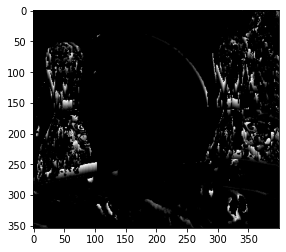

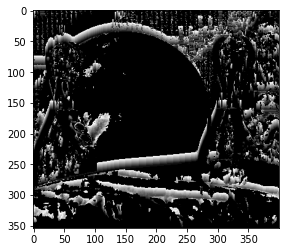

In [31]:
plt.imshow(u, cmap='gray')
plt.show()

plt.imshow(l, cmap='gray')
plt.show()

In [21]:
def getDepthMap(limg, rimg, min_d, max_d): #Omama
    min_d = 0; max_d = 16 #disparity levels
    H, W = limg.shape
    disparity = np.ones((H, W, max_d - min_d)).astype('int64')

    min_diff_img = np.zeros((H, W)) # Opposite of confidence
    min_disp_img = np.zeros((H, W))
    
    for i in range(H):
        for j in range(W):
            min_diff = 1e+7
            min_idx = 0
            for d in range(max_d - min_d):
                if (j - d) < 0:
                    disparity[i][j][d] = 1e+7
                else:
                    disparity[i][j][d] = (limg[i][j] - rimg[i][j-d])**2
                    if disparity[i][j][d] < min_diff:
                        min_diff = disparity[i][j][d]
                        min_idx = d
        
            min_diff_img[i][j] = min_diff
            min_disp_img[i][j] = min_idx
            
    conf = scale_img(1 / (min_diff_img+1))
    depth = scale_img(min_disp_img)
    
    return conf, depth

/home/jhanvi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: overflow encountered in ubyte_scalars


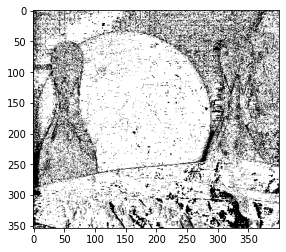

In [22]:
conf, depth = getDepthMap(limg, rimg, 0, 16)
plt.imshow(conf, cmap='gray')

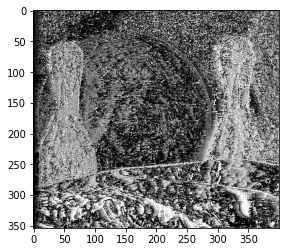

In [23]:
plt.imshow(depth, cmap='gray')